# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import inflection
import os
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
import xgboost as xgb

from keras.models import Sequential
from keras.layers import LSTM, Dense

from boruta import BorutaPy
from datetime import datetime, timedelta
from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn import ensemble as en
from sklearn import metrics as mt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import svm

warnings.filterwarnings('ignore')

## 0.1 Loading Data

In [2]:
path = 'C:/Users/edils/repos/leilao_fechamento/data/5_minutos/'

In [3]:
df_raw_list = []

for file in os.listdir(path):
    if file.endswith('.csv'):
        filename_path = os.path.join(path, file)
        df = pd.read_csv(filename_path, encoding='iso-8859-1', sep=';')
        df_raw_list.append(df)

In [4]:
df_raw = pd.concat(df_raw_list, axis=0)

In [5]:
df_raw.head()

,Ativo,Data,Hora,Abertura,Máximo,Mínimo,Fechamento,Volume,Quantidade
0,AALR3,06/06/2023,11:20:00,"23,17","23,17","23,17","23,17","4.634,00",200.0
1,AALR3,06/06/2023,11:15:00,"23,17","23,19","23,16","23,17","69.494,00",3.0
2,AALR3,06/06/2023,11:10:00,"23,19","23,19","23,18","23,18","13.912,00",600.0
3,AALR3,06/06/2023,11:05:00,"23,19","23,21","23,19","23,21","18.559,00",800.0
4,AALR3,06/06/2023,11:00:00,"23,19","23,21","23,19","23,21","34.793,00",1.5


In [6]:
df_raw.dtypes

Ativo         object
Data          object
Hora          object
Abertura      object
Máximo        object
Mínimo        object
Fechamento    object
Volume        object
Quantidade    object
dtype: object

## 0.2 Helper Functions

In [45]:
def data_types(df1):
    #abertura
    df1['abertura'] = df1['abertura'].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    df1['abertura'] = df1['abertura'].apply(lambda x: x.replace('.', '') if isinstance(x, str) else x)
    df1['abertura'] = df1['abertura'].astype(float)

    #maximo
    df1['maximo'] = df1['maximo'].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    df1['maximo'] = df1['maximo'].apply(lambda x: x.replace('.', '') if isinstance(x, str) else x)
    df1['maximo'] = df1['maximo'].astype(float)

    #minimo
    df1['minimo'] = df1['minimo'].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    df1['minimo'] = df1['minimo'].apply(lambda x: x.replace('.', '') if isinstance(x, str) else x)
    df1['minimo'] = df1['minimo'].astype(float)

    #fechamento
    df1['fechamento'] = df1['fechamento'].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    df1['fechamento'] = df1['fechamento'].apply(lambda x: x.replace('.', '') if isinstance(x, str) else x)
    df1['fechamento'] = df1['fechamento'].astype(float)

    #volume
    df1['volume'] = df1['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df1['volume'] = df1['volume'].astype(float)

    #quantidade
    df1['quantidade'] = df1['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df1['quantidade'] = df1['quantidade'].apply(lambda x: float(x))

    #data
    df1['data'] = df1['data'].apply(lambda x: x.replace('/','-'))
    df1['data'] = df1['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df1['data'] = pd.to_datetime(df1['data'], format='%d-%m-%Y')
    df1['hora'] = df1['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    
    return df1

def rename_columns(df1):
    cols_old = df1.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df1.columns = cols_new
    df1 = df1.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})
    
    return df1

def changing_time(df1):
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df1.loc[df1['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    hora_leilao = (df1['hora'].dt.hour >= 16) & (df1['hora'].dt.hour < 18) 
    df1 = df1.loc[hora_leilao,:]
    return df1

def clean_futuros(df_win):
    cols_old = df_win.columns
    cols_new = cols_old.map(lambda x: inflection.underscore(x))
    df_win.columns = cols_new
    df_win = df_win.rename(columns={'máximo': 'maximo', 'mínimo':'minimo'})

    df_win['abertura'] = df_win['abertura'].astype(float)

    #maximo

    df_win['maximo'] = df_win['maximo'].astype(float)

    #minimo

    df_win['minimo'] = df_win['minimo'].astype(float)

    #fechamento

    df_win['fechamento'] = df_win['fechamento'].astype(float)

    #volume
    df_win['volume'] = df_win['volume'].apply(lambda x: x.replace(".", "").replace(",", "."))
    df_win['volume'] = df_win['volume'].astype(float)

    #quantidade
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: x.replace(".", "") if isinstance(x, str) else x)
    df_win['quantidade'] = df_win['quantidade'].apply(lambda x: float(x))

    #data
    df_win['data'] = df_win['data'].apply(lambda x: x.replace('/','-'))
    df_win['data'] = df_win['data'].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
    df_win['data'] = pd.to_datetime(df_win['data'], format='%d-%m-%Y')
    df_win['hora'] = df_win['hora'].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    #Horário de verão 2023-03-13
    data_verao = pd.to_datetime('2023-03-13')
    df_win.loc[df_win['data'] >= data_verao, 'hora'] += pd.Timedelta(hours=1)
    
    hora_leilao = (df_win['hora'].dt.hour >= 16) & (df_win['hora'].dt.hour < 18) 
    df_win = df_win.loc[hora_leilao,:]
    
    df_win['variacao'] = (df_win['fechamento'] - df_win['abertura']) / df_win['abertura']
    
    return df_win

palette = ["#00BFFF", "#DC143C", "#FFA07A", "#FFD700", "#8B008B", "#7CFC00", "#FF69B4", "#00CED1", "#FF6347", "#9400D3"]
def jupyter_settings(palette):
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set(font_scale=2)
    sns.set_theme(palette=palette)
    warnings.simplefilter("ignore")
    # plt.rcParams.update({'font.size': 10})
    sns.set_style("white")

    
jupyter_settings(palette)
    

# 1.0 DATA DESCRIPTION

In [46]:
df1 = df_raw.copy()

In [47]:
df1

,Ativo,Data,Hora,Abertura,Máximo,Mínimo,Fechamento,Volume,Quantidade
0,AALR3,06/06/2023,11:20:00,"23,17","23,17","23,17","23,17","4.634,00",200.0
1,AALR3,06/06/2023,11:15:00,"23,17","23,19","23,16","23,17","69.494,00",3.0
2,AALR3,06/06/2023,11:10:00,"23,19","23,19","23,18","23,18","13.912,00",600.0
3,AALR3,06/06/2023,11:05:00,"23,19","23,21","23,19","23,21","18.559,00",800.0
4,AALR3,06/06/2023,11:00:00,"23,19","23,21","23,19","23,21","34.793,00",1.5
...,...,...,...,...,...,...,...,...,...
10027,ZAMP3,19/12/2022,16:55:00,"4,53","4,54","4,53","4,54","29.498,00",6.500
10028,ZAMP3,19/12/2022,16:50:00,"4,54","4,55","4,53","4,53","69.912,00",15.400
10029,ZAMP3,19/12/2022,16:45:00,"4,57","4,57","4,54","4,54","36.878,00",8.100
10030,ZAMP3,19/12/2022,16:40:00,"4,57","4,58","4,56","4,56","18.266,00",4.000


## 1.1 Rename Columns

In [48]:
df1 = rename_columns(df1)

## 1.2 Data Types

In [49]:
df1.dtypes

ativo         object
data          object
hora          object
abertura      object
maximo        object
minimo        object
fechamento    object
volume        object
quantidade    object
dtype: object

In [50]:
df1 = data_types(df1)

## 1.3 Check NA

In [51]:
df1.isna().sum()

ativo         0
data          0
hora          0
abertura      0
maximo        0
minimo        0
fechamento    0
volume        0
quantidade    0
dtype: int64

## 1.4 Data Shape

In [52]:
df1.shape

(2973670, 9)

## 1.5 Changing Time

In [53]:
df1 = changing_time(df1)

## 1.6 Create Response Variable

In [54]:
df1['variacao'] = (df1['fechamento'] - df1['abertura']) / df1['abertura']

In [56]:
df1.head()

,ativo,data,hora,abertura,maximo,minimo,fechamento,volume,quantidade,variacao
16,AALR3,2023-06-05,1900-01-01 17:50:00,2320.0,2320.0,2315.0,2315.0,1317308.0,56.9,-0.002155
17,AALR3,2023-06-05,1900-01-01 17:45:00,2321.0,2321.0,2318.0,2318.0,13918.0,600.0,-0.001293
18,AALR3,2023-06-05,1900-01-01 17:40:00,2320.0,2322.0,2316.0,2319.0,171597.0,7.4,-0.000431
19,AALR3,2023-06-05,1900-01-01 17:35:00,2318.0,2320.0,2318.0,2319.0,18554.0,800.0,0.000431
20,AALR3,2023-06-05,1900-01-01 17:30:00,2318.0,2324.0,2318.0,2319.0,41777.0,1.8,0.000431


# 2.0 Feature Engineering

In [67]:
df2 = df1.copy()

In [85]:
df2.head()

,ativo,data,hora,abertura,maximo,minimo,fechamento,volume,quantidade,variacao,tipo_candle
16,AALR3,2023-06-05,1900-01-01 17:50:00,2320.0,2320.0,2315.0,2315.0,1317308.0,56.9,-0.002155,negativo
17,AALR3,2023-06-05,1900-01-01 17:45:00,2321.0,2321.0,2318.0,2318.0,13918.0,600.0,-0.001293,negativo
18,AALR3,2023-06-05,1900-01-01 17:40:00,2320.0,2322.0,2316.0,2319.0,171597.0,7.4,-0.000431,negativo
19,AALR3,2023-06-05,1900-01-01 17:35:00,2318.0,2320.0,2318.0,2319.0,18554.0,800.0,0.000431,positivo
20,AALR3,2023-06-05,1900-01-01 17:30:00,2318.0,2324.0,2318.0,2319.0,41777.0,1.8,0.000431,positivo


## Selecionar os ultimos 30 dias uteis

In [140]:
ultimos_30_dias = df2['data'].unique()[:30]

In [143]:
df2_30 = df2.loc[df2['data'].isin(ultimos_30_dias),:]

## Candle Positivo/Negativo

In [69]:
df2_30['tipo_candle'] = np.zeros
df2_30['tipo_candle'] = df2_30.apply(lambda x: 'positivo' if x['variacao'] > 0 else ('zero' if x['variacao'] == 0 else 'negativo'), axis=1)

## Separar em primeira e segunda hora

In [154]:
df_primeira_hora = df2_30.loc[df2_30['hora'].dt.hour < 17,:]
df_segunda_hora = df2_30.loc[(df2_30['hora'].dt.hour >= 17) & (df2_30['hora'].dt.minute != 50),:]
df_leilao = df2_30.loc[(df2_30['hora'].dt.hour >= 17) & (df2_30['hora'].dt.minute == 50),:]

## Separar 1,3,5,7,10,15,20,25,30 dias

In [190]:
dias_lista = [1,3,5,7,10,15,20,25,30]
df_dias = {}

for dias in dias_lista:
    ultimos_dias = df2_30['data'].unique()[:dias]
    df_filtrado = df2_30.loc[df2_30['data'].isin(ultimos_dias),:]
    df_dias[dias] = df_filtrado.copy()

In [197]:
df_dias[3]

,ativo,data,hora,abertura,maximo,minimo,fechamento,volume,quantidade,variacao,tipo_candle
16,AALR3,2023-06-05,1900-01-01 17:50:00,2320.0,2320.0,2315.0,2315.0,1317308.0,56.9,-0.002155,negativo
17,AALR3,2023-06-05,1900-01-01 17:45:00,2321.0,2321.0,2318.0,2318.0,13918.0,600.0,-0.001293,negativo
18,AALR3,2023-06-05,1900-01-01 17:40:00,2320.0,2322.0,2316.0,2319.0,171597.0,7.4,-0.000431,negativo
19,AALR3,2023-06-05,1900-01-01 17:35:00,2318.0,2320.0,2318.0,2319.0,18554.0,800.0,0.000431,positivo
20,AALR3,2023-06-05,1900-01-01 17:30:00,2318.0,2324.0,2318.0,2319.0,41777.0,1.8,0.000431,positivo
21,AALR3,2023-06-05,1900-01-01 17:25:00,2320.0,2321.0,2318.0,2320.0,27834.0,1.2,0.000000,zero
22,AALR3,2023-06-05,1900-01-01 17:20:00,2314.0,2320.0,2314.0,2320.0,27811.0,1.2,0.002593,positivo
23,AALR3,2023-06-05,1900-01-01 17:15:00,2310.0,2314.0,2310.0,2314.0,39299.0,1.7,0.001732,positivo
24,AALR3,2023-06-05,1900-01-01 17:10:00,2311.0,2312.0,2310.0,2312.0,13866.0,600.0,0.000433,positivo
25,AALR3,2023-06-05,1900-01-01 17:05:00,2311.0,2311.0,2310.0,2310.0,11553.0,500.0,-0.000433,negativo


## Média e Dias Positivos Primeira Hora

In [174]:
df_med_pos_neg_primeira_hora = (df_primeira_hora.loc[df_primeira_hora['tipo_candle'] == 'positivo',['ativo','data','variacao','volume','tipo_candle']]
                      .groupby(['ativo', 'data'])
                      .agg(medias = ('variacao', 'mean'),
                           std = ('variacao', 'std'),
                           num_pos = ('tipo_candle', lambda x: (x == 'positivo').sum()),
                           med_volume = ('volume', 'mean')).reset_index())

In [175]:
df_med_pos_neg_primeira_hora.sort_values(by=['ativo','data'], ascending=[True, False])

,ativo,data,medias,std,num_pos,med_volume
29,AALR3,2023-06-05,0.001887,0.001341,6,82565.333333
28,AALR3,2023-06-02,0.000728,0.000356,6,82816.500000
27,AALR3,2023-06-01,0.000944,0.000328,6,34446.833333
26,AALR3,2023-05-31,0.000582,0.000252,3,21376.000000
25,AALR3,2023-05-30,0.000750,0.000417,7,21878.285714
...,...,...,...,...,...,...
7539,ZAMP3,2023-04-28,0.003680,0.001426,4,69240.500000
7538,ZAMP3,2023-04-27,0.002516,0.000004,2,9552.000000
7537,ZAMP3,2023-04-26,0.007626,0.007177,4,141301.250000
7536,ZAMP3,2023-04-25,0.005758,0.002870,5,31804.400000


In [177]:
df_resume = (df_med_pos_neg_primeira_hora.loc[:,['ativo','medias','num_pos','med_volume','std']].groupby(['ativo'])
                            .agg(media = ('medias','mean'),
                                 std = ('std', 'std'),
                                 num_pos = ('num_pos', 'sum'),
                                 med_volume = ('med_volume', 'mean')).reset_index()).sort_values(by='media', ascending=False)

In [178]:
df_resume = df_resume.loc[df_resume['med_volume'] > 500000,:]
df_resume['med_volume'] = df_resume['med_volume']/100000
df_resume['media'] = df_resume['media']*100
df_resume['std'] = df_resume['std']*100

In [182]:
df_resume.sort_values(by=['num_pos'], ascending=[False]).head(20)

,ativo,media,std,num_pos,med_volume
235,SMAL11,0.086403,0.040185,185,40.845432
133,IVVB11,0.055015,0.017415,180,8.667942
280,XPBR31,0.147779,0.040408,177,5.054878
279,WSPFUT,0.044207,0.013410,176,15.994395
81,ELET6,0.109681,0.084491,176,13.435217
226,SBSP3,0.104731,0.043427,174,15.603713
17,ARZZ3,0.193897,0.078784,173,15.840215
244,TAEE11,0.081118,0.022477,171,8.260517
128,IRBR3,0.220689,0.072340,170,9.821958
275,WDOFUT,0.043315,0.016500,169,10429.576147


## Média e Dias Positivos Primeira Hora

## % Winfut

In [44]:
# #create futures variation
# df_win = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/futuros/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')
# # df_dol = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/futuros/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')
# # df_sp = pd.read_csv('C:/Users/edils/repos/leilao_fechamento/data/futuros/WINFUT_F_0_5min.csv', encoding='iso-8859-1', sep=';')

# df_win = clean_futuros(df_win)
# # df_dol = clean_futuros(df_dol)
# # df_sp = clean_futuros(df_sp)

In [45]:
# df2 = pd.merge(df2, df_win[['data','hora','variacao']], on=['data','hora'], how='left')
# df2 = df2.rename(columns={'variacao_x':'variacao', 'variacao_y':'variacao_win'})


In [46]:
# df2 = df2.dropna()

# 3.0 EDA

In [48]:
df3 = df2.copy()

In [49]:
numerical_attributes = df3.select_dtypes(include=['float64','datetime64[ns]'])

In [50]:
stats = numerical_attributes.agg(['min','max', lambda x: max(x)-min(x),'mean','std','skew', 'kurtosis']).T

In [51]:
stats

,min,max,<lambda>,mean,std,skew,kurtosis
data,2023-01-06 00:00:00,2023-05-04 00:00:00,118 days 00:00:00,2023-03-05 01:51:13.035680,34 days 06:26:48.341962556,NaN,NaN
hora,1900-01-01 16:00:00,1900-01-01 17:50:00,0 days 01:50:00,1900-01-01 16:55:13.611250432,0 days 00:33:13.265610203,NaN,NaN
maximo,0.33,240.0,239.67,16.214881,20.997625,5.277196,43.606413
minimo,0.33,238.62,238.29,16.169963,20.961162,5.281476,43.664698
volume,4.64,1947680443.0,1947680438.36,1414418.319905,8999845.506107,72.166575,10670.239713
quantidade,1.0,94180900.0,94180899.0,96846.140049,533635.17791,56.352781,6764.730224
variacao,-0.125,0.125,0.25,0.000032,0.004307,1.001705,116.691997
variacao_win,-0.007396,0.005519,0.012915,-0.000006,0.000932,-0.069485,5.040173


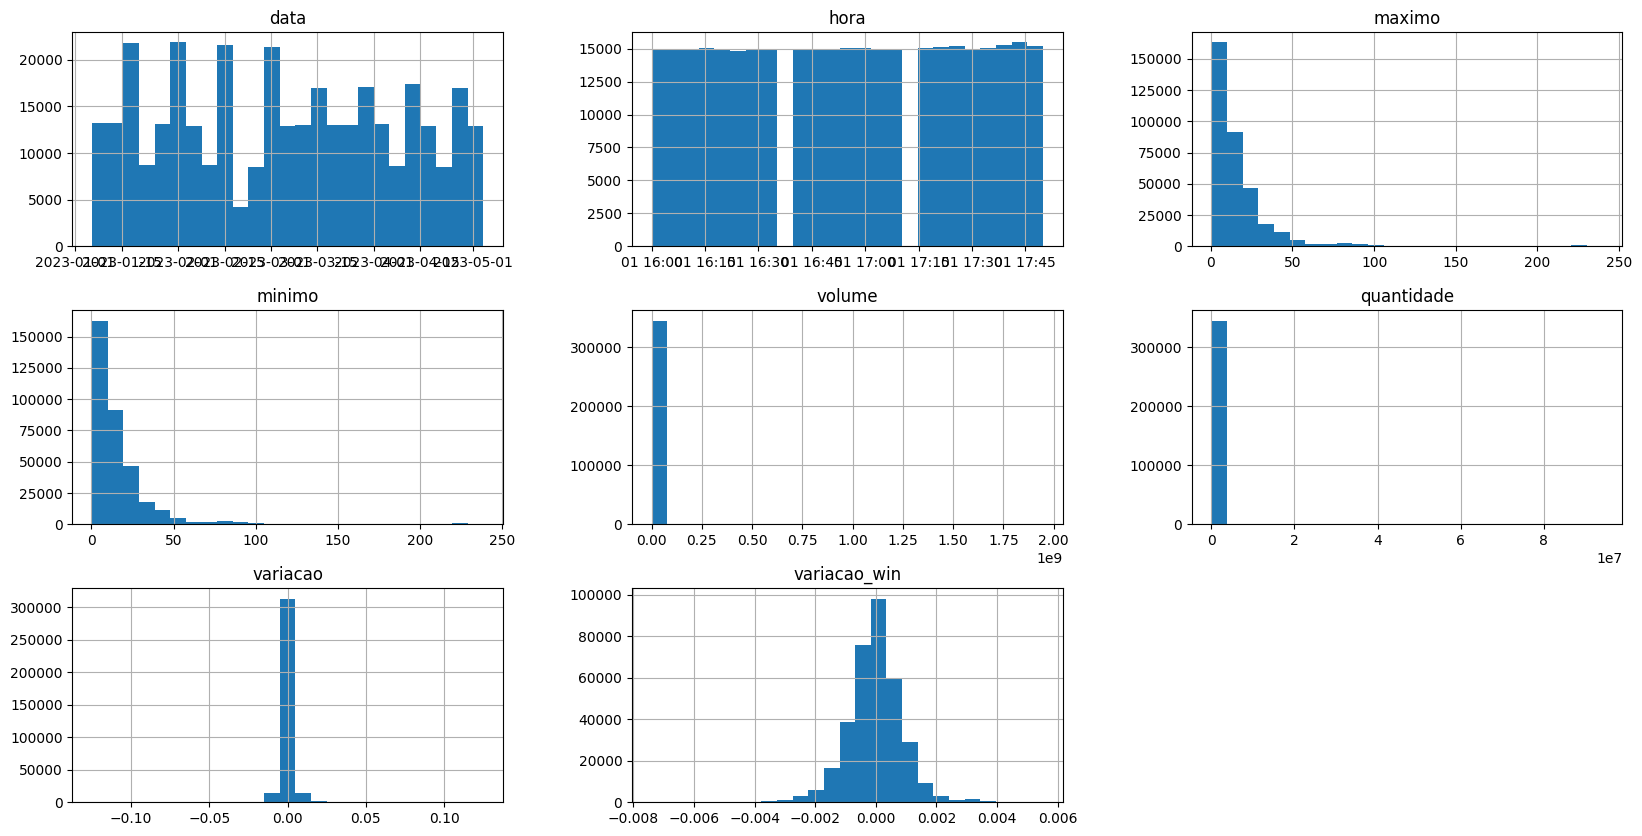

In [52]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
numerical_attributes.hist(ax = ax, bins=25);

<Axes: >

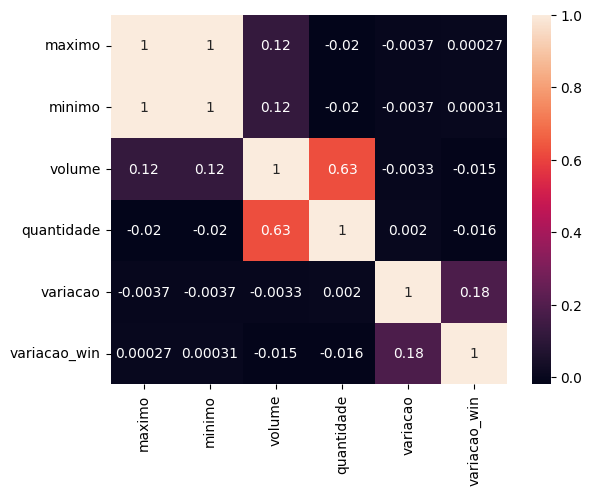

In [53]:
sns.heatmap(numerical_attributes.corr(method='pearson'), annot=True)

# 4.0 Data Preparation

In [104]:
df4 = df3.copy()

In [105]:
df4.head()

,ativo,data,hora,maximo,minimo,volume,quantidade,variacao,variacao_win
4,VITT3,2023-02-01,1900-01-01 17:25:00,12.09,12.05,18114.0,1500.0,-0.002483,0.000352
7,WEGE3,2023-01-17,1900-01-01 17:30:00,38.23,38.16,1253692.0,32600.0,0.001048,-0.000129
11,FRTA3,2023-01-23,1900-01-01 16:20:00,2.67,2.67,267.0,100.0,0.000000,-0.000043
12,CAML3,2023-03-10,1900-01-01 17:15:00,7.61,7.59,80566.0,10600.0,-0.001316,-0.001200
14,CVCB3,2023-03-03,1900-01-01 17:40:00,2.81,2.79,449133.0,160400.0,0.003584,-0.000523


## 4.1 Rescalling 

In [106]:
ss = StandardScaler()
mms = MinMaxScaler()

#Poisson -> abertura, maximo, minimo fechamento Usar 
df4['maximo'] = mms.fit_transform(df4['maximo'].values.reshape(-1,1))
df4['minimo'] = mms.fit_transform(df4['minimo'].values.reshape(-1,1))
df4['volume'] = mms.fit_transform(df4['volume'].values.reshape(-1,1))
df4['quantidade'] = mms.fit_transform(df4['quantidade'].values.reshape(-1,1))
df4['variacao'] = mms.fit_transform(df4['variacao'].values.reshape(-1,1))
df4['variacao_win'] = mms.fit_transform(df4['variacao_win'].values.reshape(-1,1))

In [107]:
numerical_attributes_transformed = df4.select_dtypes(include='float64')

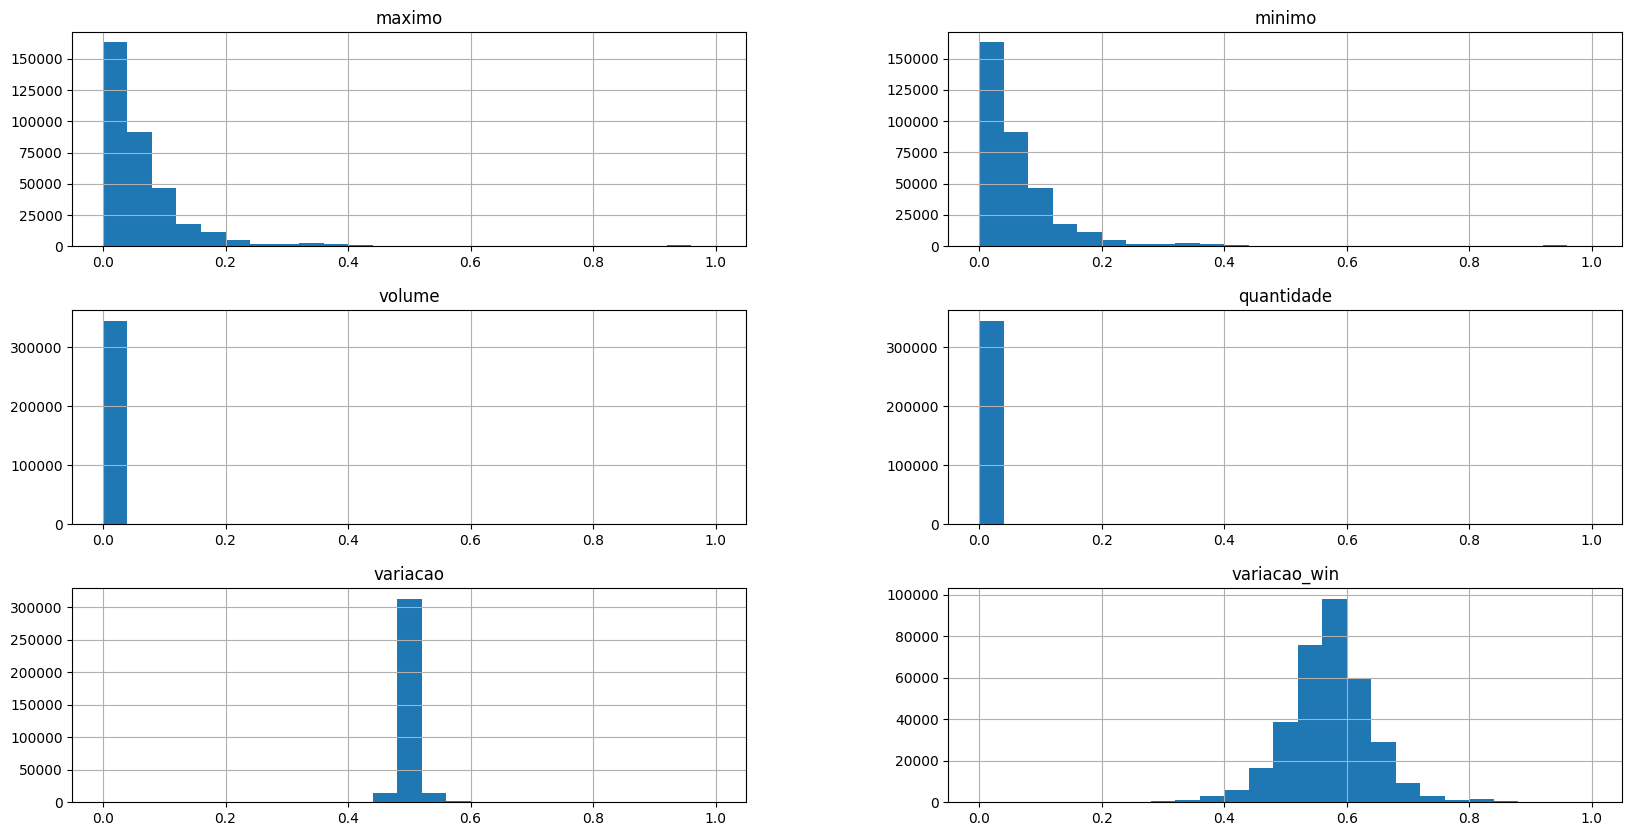

In [108]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
numerical_attributes_transformed.hist(ax = ax, bins=25);

## 4.2 Nature Transformation

In [109]:
df4['data_sin'] = df4['data'].apply(lambda x: np.sin((x.day * (2. * np.pi/21)) + (x.month * (2. * np.pi/12))))
df4['data_cos'] = df4['data'].apply(lambda x: np.cos((x.day * (2. * np.pi/21)) + (x.month * (2. * np.pi/12))))

df4['hora_sin'] = df4['hora'].apply(lambda x: np.sin((x.hour * (2. * np.pi/24)) + (x.minute * (2.*np.pi/60))))
df4['hora_cos'] = df4['hora'].apply(lambda x: np.cos((x.hour * (2. * np.pi/24)) + (x.minute * (2.*np.pi/60))))


## 4.3 Encoding

In [110]:
#Frequency encoding no ativo
fe_ativo = df4['ativo'].value_counts(normalize=True)
df4['ativo'] = df4['ativo'].map(fe_ativo)

## 4.4 Split train Validation

In [137]:
X = df4.drop('variacao', axis=1).copy()
y = df4['variacao']

In [138]:
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=0)

# 5.0 Feature Selection

## 5.1 Boruta

In [63]:
#Retirar datetime para usra no boruta
x_train_boruta = X_train.drop(columns=(['data','hora'])).copy()

In [64]:
rf = en.RandomForestRegressor(n_jobs=-1)

In [65]:
x_train_n = x_train_boruta.values
y_train_n = y_train.values
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0


KeyboardInterrupt: 

In [48]:
cols_boruta = boruta.support_.tolist()

In [51]:
x_train_selected_boruta = x_train_boruta.loc[:,cols_boruta].columns.tolist()

In [52]:
x_train_selected_boruta

['abertura', 'fechamento', 'volume', 'quantidade', 'variacao_win']

## 5.2 Extratree Regressor

In [113]:
et = en.RandomForestRegressor(n_jobs=-1)

In [114]:
et.fit(x_train_n, y_train_n)

RandomForestRegressor(n_jobs=-1)

In [115]:
importances = et.feature_importances_
features = {}

for i in range(len(x_train_boruta.columns)):
    features[x_train_boruta.columns[i]] = importances[i]
    
features = pd.DataFrame(features, index=[0])    
features = features.melt(var_name='Features', value_name='Ranking')
features.sort_values(ascending=False, by='Ranking')

,Features,Ranking
3,volume,0.172512
4,quantidade,0.153515
5,variacao_win,0.124016
2,minimo,0.118528
0,ativo,0.111949
1,maximo,0.106947
7,data_cos,0.059218
6,data_sin,0.057037
9,hora_cos,0.048336
8,hora_sin,0.047942


In [139]:
cols_selected = {'volume','quantidade','variacao_win','minimo','ativo','maximo'}

# 6.0 Machine Learning

In [140]:
x_train = X_train.loc[:,cols_selected]
x_val = X_val.loc[:,cols_selected]

## 6.1 Average Model

In [118]:
aux1 = x_train.copy()
aux1['variacao'] = y_train.copy()

#prediction
media_aux1 = aux1.loc[:,['ativo','variacao']].groupby('ativo').mean().reset_index().rename(columns={'variacao':'prediction'})
aux1 = pd.merge(aux1, media_aux1, how='left', on='ativo')
yhat_baseline = aux1['prediction']

#performance
metrics_avg = ml_error( 'Average Model', y_train, yhat_baseline )


## 6.2 Linear Regression

In [119]:
lr = LinearRegression()

lr.fit(x_train, y_train)

yhat_lr = lr.predict(x_val)

In [120]:
metrics_lr = ml_error('Linear Regression', y_val, yhat_lr)

## 6.3 Linear Regression LASSO

In [121]:
lasso = Lasso(alpha=0.01)

lasso.fit(x_train, y_train)

yhat_lasso = lasso.predict(x_val)

In [122]:
metrics_lasso = ml_error('Lasso', y_val, yhat_lasso)

## 6.4 Random Forest

In [123]:
rf = en.RandomForestRegressor(n_jobs=-1)

rf.fit(x_train, y_train)

yhat_rf = rf.predict(x_val)

In [124]:
metrics_rf = ml_error('Random Forest', y_val, yhat_rf )

##  6.5 XGBoost

In [125]:
xgb_model = xgb.XGBRegressor()

xgb_model.fit(x_train, y_train)

yhat_xgb = xgb_model.predict(x_val)


In [126]:
metrics_xgb = ml_error('XGBoost', y_val, yhat_xgb)

## 6.6 SVM

In [127]:
model_svm = svm.LinearSVR()

model_svm.fit(x_train, y_train)

yhat_svm = model_svm.predict(x_val)

In [128]:
metrics_svm = ml_error('SVM', y_val, yhat_svm)

## 6.7 LSTM

In [141]:
x_train_exp = np.expand_dims(x_train, axis=2)
x_val_exp = np.expand_dims(x_val, axis=2)

# Definir o número de características
n_features = len(cols_selected)

# Definir o modelo LSTM
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_features, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
model.fit(x_train_exp, y_train, epochs=10, batch_size=32, validation_data=(x_val_exp, y_val))

In [132]:
yhat_lstm = model.predict(x_val_exp)

2162/2162 [==============================] - 3s 2ms/step


In [134]:
yhat_lstm

array([[0.4946571 ],
       [0.49360162],
       [0.49754885],
       ...,
       [0.49917766],
       [0.50005484],
       [0.49941757]], dtype=float32)

In [145]:
y_val

294141    0.509193
369058    0.516000
233257    0.496974
358349    0.495280
38777     0.472943
            ...   
327888    0.518519
473282    0.500000
104558    0.488701
282707    0.486885
440976    0.502625
Name: variacao, Length: 69177, dtype: float64

In [142]:
ml_error('LSTM', y_val, yhat_lstm)

,Model Name,MAE,MAPE,RMSE
0,LSTM,0.008337,0.017067,0.017245


## 6.7 Model Perfomance Compare

In [143]:
metrics = pd.concat([metrics_avg, metrics_lr, metrics_lasso, metrics_rf, metrics_xgb, metrics_svm])

In [144]:
metrics.sort_values(by='RMSE')

,Model Name,MAE,MAPE,RMSE
0,Average Model,0.008332,8.244356e+09,0.017119
0,Linear Regression,0.008178,1.682804e-02,0.017181
0,SVM,0.008114,1.667754e-02,0.017213
0,XGBoost,0.008184,1.682697e-02,0.017359
0,Lasso,0.008247,1.694171e-02,0.017444
0,Random Forest,0.008535,1.752849e-02,0.017927


In [102]:
y_val

294141    0.526169
369058    0.921279
233257   -0.183071
358349   -0.281402
38777    -1.577998
            ...   
327888    1.067467
473282   -0.007443
104558   -0.663320
282707   -0.768690
440976    0.144907
Name: variacao, Length: 69177, dtype: float64

In [103]:
yhat_xgb

array([-0.20773979, -0.26806396, -0.05848419, ...,  0.02295487,
        0.13367519,  0.08648355], dtype=float32)

## 6.8 Cross Validation

In [116]:
x_cross = X.loc[:,cols_selected]

In [ ]:
lr_cross_val = ms.cross_val_score(lr, x_cross, y, cv=5 )

In [128]:
print(np.mean(lr_cross_val))

0.9994839888425145
